# Analysis and visualization of spatial transcriptomics data

This tutorial demonstrates how to work with spatial transcriptomics data with **Scanpy**. 

The analysis pipeline largely recapitulates the standard **Scanpy** workflow and builds upon our best practices [tutorial](https://github.com/theislab/single-cell-tutorial).  
Here, we show how to use Scanpy to analyse spatial data using our custom spatial visualization function and an external tool. In this tutorial we focus on 10x genomics [Visium](https://www.10xgenomics.com/spatial-transcriptomics/) spatial transcriptomics data. 

This tutorial was generated using the `spatial` branch of scanpy using the [spatialDE](https://www.nature.com/articles/nmeth.4636) package. To run the tutorial, please run the following commands to use the correct branch and install the dependency

```
pip install git+https://github.com/theislab/scanpy.git@spatial
pip install spatialde
```

### Loading libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb

import SpatialDE

plt.rcParams['figure.figsize']=(8,8)

%load_ext autoreload
%autoreload 2

### Reading the data

We will use a **Visium** spatial transcriptomics dataset of the human lymphnode, which is publicly available from the 10x genomics website: [link](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Human_Lymph_Node)

The function `datasets.visium_sge()` downloads the dataset from 10x genomics and returns an AnnData object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with `pp.calculate_qc_metrics` and percentage of mitochondrial read counts per sample.

In [2]:
adata = sc.datasets.visium_sge('V1_Human_Lymph_Node')
adata.var_names_make_unique()

sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata[:, adata.var['mt']].X.sum(1).A.squeeze()/adata.obs['total_counts']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### QC and preprocessing

Furthermore, we will perform some basic filtering of spots based on total counts and expressed genes

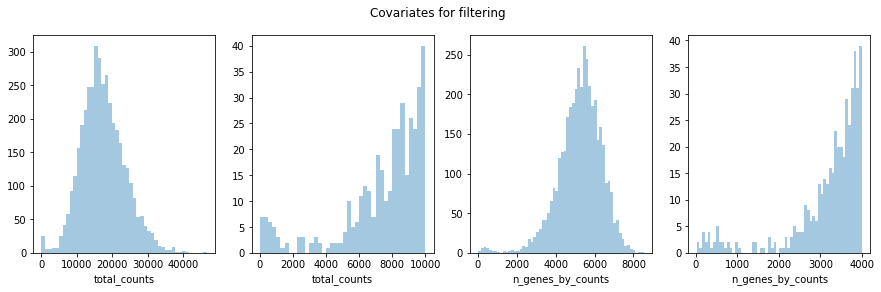

In [3]:
fig, axs = plt.subplots(1,4, figsize=(15,4))
fig.suptitle('Covariates for filtering')
sb.distplot(adata.obs['total_counts'], kde=False, ax = axs[0])
sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<10000], kde=False, bins=40, ax = axs[1])
sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax = axs[2])
sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<4000], kde=False, bins=60, ax = axs[3])

In [4]:
sc.pp.filter_cells(adata, min_counts = 5000)
print(f'Number of cells after min count filter: {adata.n_obs}')
sc.pp.filter_cells(adata, max_counts = 35000)
print(f'Number of cells after max count filter: {adata.n_obs}')
adata = adata[adata.obs['mt_frac'] < 0.2]
print(f'Number of cells after MT filter: {adata.n_obs}')
sc.pp.filter_cells(adata, min_genes = 3000)
print(f'Number of cells after gene filter: {adata.n_obs}')
sc.pp.filter_genes(adata, min_cells=10)
print(f'Number of genes after cell filter: {adata.n_vars}')

Number of cells after min count filter: 3988
Number of cells after max count filter: 3962
Number of cells after MT filter: 3962


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 3895
Number of genes after cell filter: 18457


We proceed to normalize Visium counts data with the built-in `normalize_total` method from Scanpy, and detect highly-variable genes (for later). Note that there are more sensible alternatives for normalization (see discussion in [sc-tutorial paper](https://www.embopress.org/doi/full/10.15252/msb.20188746) and more recent alternatives such as [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) or [GLM-PCA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)).

In [5]:
sc.pp.normalize_total(adata, inplace = True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, inplace=True)

### Dimensionality reduction and clustering

We can then proceed to run dimensionality reduction and clustering. We will plot some covariates to check if there is any particular structure in UMAP space associated with total counts and detected genes.

In [6]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.louvain(adata, key_added='clusters')

... storing 'feature_types' as categorical
... storing 'genome' as categorical


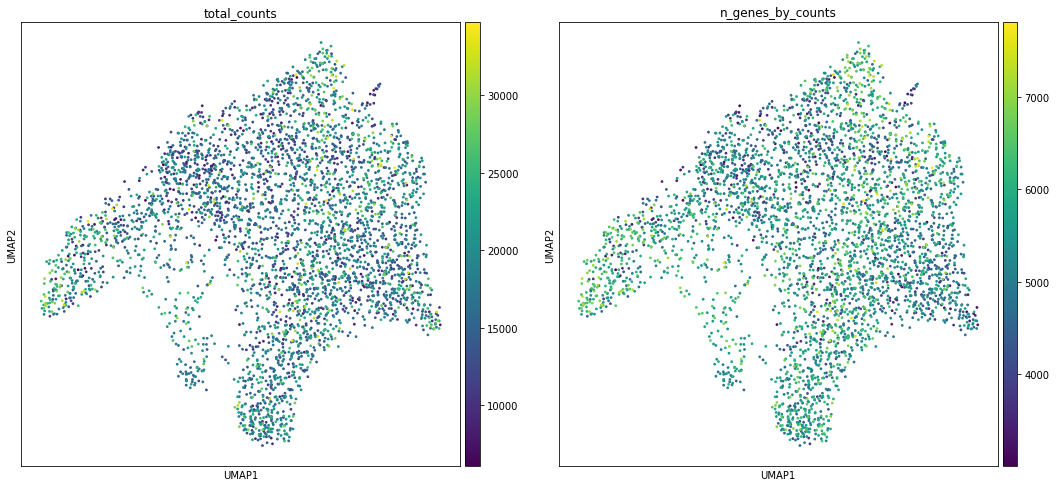

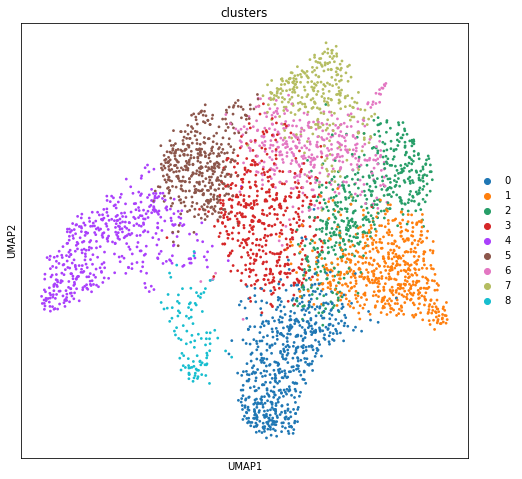

In [7]:
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts'])
sc.pl.umap(adata, color='clusters', palette=sc.pl.palettes.default_20)

### Visualization in spatial dimensions

We visualized two covariates (total counts per spot and number of genes by counts) in UMAP space. We can have a look at how the covariates are projected onto the spatial coordinates. We will overlay the circular spots on top of the Hematoxylin and eosin stain (H&E) image provided, using the function `pl.spatial`.

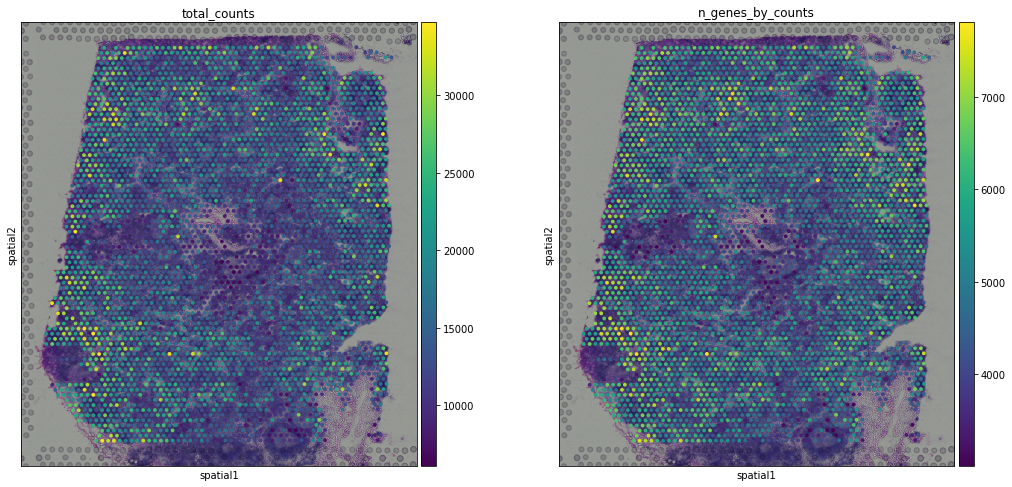

In [8]:
sc.pl.spatial(adata, img_key = "hires",color=['total_counts', 'n_genes_by_counts'])

the function `pl.spatial` accepts 4 additional parameters:
* **img_key** *str*: key where the img is stored in the `adata.uns` element
* **crop_coord** *tuple*: coordinates to use for cropping (left, right, top, bottom)
* **alpha_img** *float*: alpha value for the transcparency of the image
* **bw** *bool*: flag to convert the image into gray scale  

furthermore, in `pl.spatial` the **size** parameter changes its behaviour: it becomes a scaling factor for the spot sizes.

Before, we performed clustering in gene expression space, and visualized the results with UMAP. By visualizing clustered samples in spatial dimensions, we can gain insights into tissue organization and inter-cellular communication.

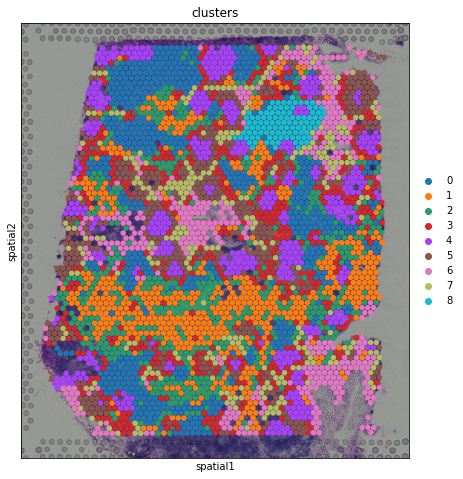

In [9]:
sc.pl.spatial(adata, img_key = "hires", color="clusters", size=1.5)

From a visual perspective, spots belonging to the same cluster in gene expression space seems to co-occur in spatial dimensions. For instance, spots belonging to cluster 4 seem to always be surrounded by spots belonging to cluster 5.

We can zoom in specific regions of interests to gain qualitative insights. Furthermore, by changing the alpha values of the spots, we can visualize better the underlying tissue morphology from the H&E image.

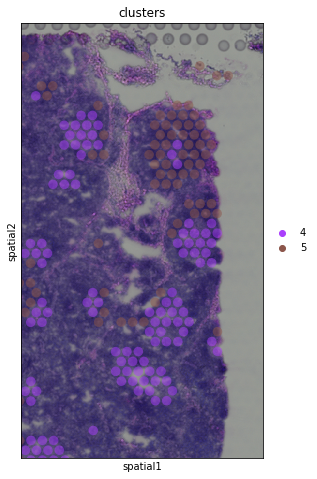

In [10]:
sc.pl.spatial(adata, img_key = "hires", color="clusters", groups = ["4","5"], crop_coord = [1200,1700,1900,1000], alpha = .5, size = 1.3)

### Identification of marker genes and spatially variable genes

After clustering, we can proceed to identify cluster marker genes.

categories: 0, 1, 2, etc.
var_group_labels: 4


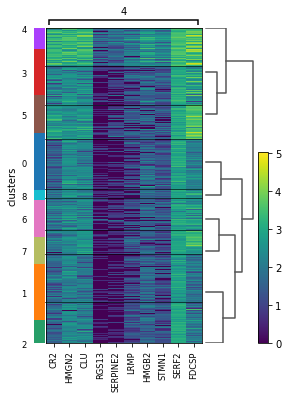

In [11]:
sc.tl.rank_genes_groups(adata, "clusters", inplace = True)
sc.pl.rank_genes_groups_heatmap(adata, groups = "4", groupby = "clusters", show = False)

Given the spatial organization of cluster 4, which seemed to occur in small groups of spots across the image, we have plotted a heatmap with expression levels of its top 10 marker genes across clusters.

We can have a look at one specific gene and notice that it already show some interesting structural expression patterns in the image.

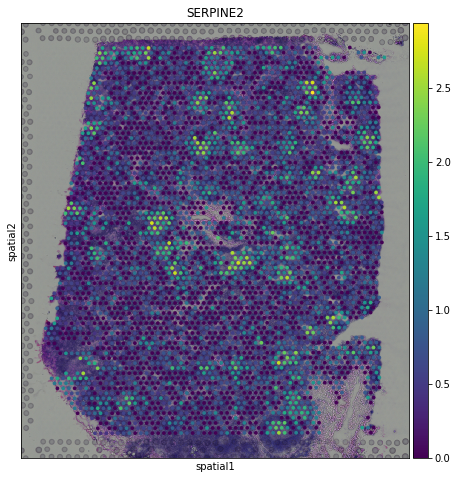

In [12]:
sc.pl.spatial(adata, img_key = "hires", color="SERPINE2")

Spatial transcriptomics allows researchers to investigate how gene expression trends varies in space, thus identifying spatial patterns of gene expression. For this purpose, we use **SpatialDE** ([paper](https://www.nature.com/articles/nmeth.4636) - [code](https://github.com/Teichlab/SpatialDE)), a Gaussian process-based statistical framework that aims to identify spatially variable genes.

First, we convert normalized counts and coordinates to pandas dataframe, needed for inputs to spatialDE. Then we can run the method.

In [13]:
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm["X_spatial"], columns=["x_coord", "y_coord"], index = adata.obs_names)

results = SpatialDE.run(coord, counts)

/Users/giovanni.palla/Projects/SpatialDE/Python-module/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


We concatenate the results with the variable table `adata.var`

In [14]:
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values,:]], axis = 1)

Then we can inspect significant genes that varies in space and visualize them with `sc.pl.spatial` function.

In [15]:
results.sort_values("qval").head(10)

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
g,,,,,,,,,,,,,,,,,,
ITGAX,0.170702,4,ITGAX,248.801360,4.832369,-3302.354218,0.978878,0.095954,SE,3895,0.000005,0.000257,0.002626,6637.778231,-3430.115338,127.761120,0.0,0.0
CTGF,0.208433,4,CTGF,248.801360,3.777540,-3601.962867,1.059363,0.131464,SE,3895,0.000004,0.000154,0.002593,7236.995531,-3820.898121,218.935254,0.0,0.0
RPS12,0.578740,4,RPS12,248.801360,0.724028,1282.631794,4.262369,0.896279,SE,3895,0.000002,0.000044,0.002194,-2532.193792,132.889696,1149.742098,0.0,0.0
PIK3IP1,0.165093,4,PIK3IP1,474.169746,4.960988,-3121.508186,1.247603,0.075819,SE,3895,0.000013,0.000647,0.002727,6276.086168,-3327.150590,205.642404,0.0,0.0
CSF2RB,0.118427,4,CSF2RB,474.169746,7.302389,-3455.655137,1.032037,0.058573,SE,3895,0.000017,0.001423,0.002386,6944.380070,-3549.412548,93.757410,0.0,0.0
RAC2,0.188012,4,RAC2,474.169746,4.236631,-1862.354983,2.130281,0.095923,SE,3895,0.000017,0.000701,0.002674,3757.779762,-2074.893341,212.538358,0.0,0.0
DDX17,0.080435,4,DDX17,474.169746,11.214828,-1099.271702,2.480615,0.084385,SE,3895,0.000009,0.001430,0.007070,2231.613199,-1177.162770,77.891068,0.0,0.0
EZR,0.237460,4,EZR,248.801360,3.194199,-2561.906858,1.833875,0.199101,SE,3895,0.000004,0.000124,0.002783,5156.883512,-2825.270277,263.363418,0.0,0.0
CTLA4,0.114898,4,CTLA4,474.169746,7.556782,-2927.151343,0.548249,0.036851,SE,3895,0.000013,0.001080,0.002408,5887.372483,-3057.224784,130.073441,0.0,0.0


... storing 'model' as categorical


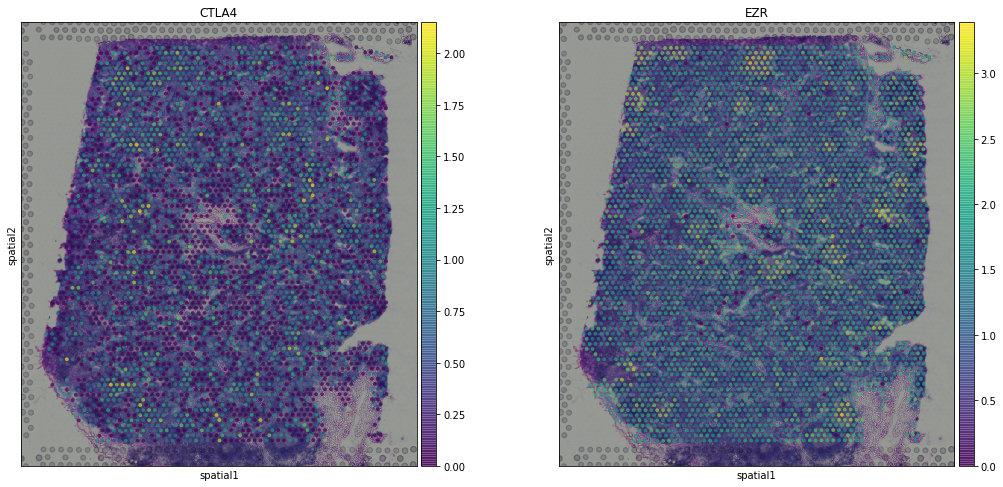

In [16]:
sc.pl.spatial(adata,img_key = "hires",color = ["CTLA4", "EZR"], alpha = 0.7)

Recently, other tools have been proposed for the identification of spatially variable genes, such as:
* **SPARK** [paper](https://www.nature.com/articles/s41592-019-0701-7#Abs1) - [code](https://github.com/xzhoulab/SPARK)
* **trendsceek** [paper](https://www.nature.com/articles/nmeth.4634) - [code](https://github.com/edsgard/trendsceek)
* **HMRF** [paper](https://www.nature.com/articles/nbt.4260) - [code](https://bitbucket.org/qzhudfci/smfishhmrf-py/src/default/)

### MERFISH example

In case you have spatial data generated with FISH-based techniques, just read the cordinate table and assign it to the `adata.obsm` element. 

Let's see an example from [Xia et al. 2019](https://www.pnas.org/content/116/39/19490.abstract).

First, we need to download the coordinate and counts data from the [original publication](https://www.pnas.org/content/116/39/19490/tab-figures-data).
We will download the files in the current directory...

In [18]:
import urllib.request
url_coord = 'https://www.pnas.org/highwire/filestream/887973/field_highwire_adjunct_files/15/pnas.1912459116.sd15.xlsx'
filename_coord = 'pnas.1912459116.sd15.xlsx'
urllib.request.urlretrieve(url_coord, filename_coord)

url_counts = 'https://www.pnas.org/highwire/filestream/887973/field_highwire_adjunct_files/12/pnas.1912459116.sd12.csv'
filename_counts = 'pnas.1912459116.sd12.csv'
urllib.request.urlretrieve(url_counts, filename_counts)

('pnas.1912459116.sd12.csv', <http.client.HTTPMessage at 0x1a3a7f8850>)

..and read the data in a AnnData object.

In [19]:
coordinates = pd.read_excel("./pnas.1912459116.sd15.xlsx", index_col = 0)
counts = sc.read_csv("./pnas.1912459116.sd12.csv").transpose()

adata_merfish = counts[coordinates.index,:]
adata_merfish.obsm["X_spatial"] = coordinates.to_numpy()

We will perform standard preprocessing and dimensionality reduction.

In [20]:
sc.pp.normalize_per_cell(adata_merfish, counts_per_cell_after=1e6)
sc.pp.log1p(adata_merfish)

sc.pp.pca(adata_merfish, n_comps=15)
sc.pp.neighbors(adata_merfish)
sc.tl.louvain(adata_merfish, key_added='groups', resolution=0.5)

The experiment consisted in measuring gene expression counts from a single cell type (cultured U2-OS cells). Clusters consist of cell states at different stages of the cell cycle. We don't expect to see specific structure in spatial dimensions given the experimental setup.

We can visualize the clusters obtained from running the Louvain algorithm in tSNE space...

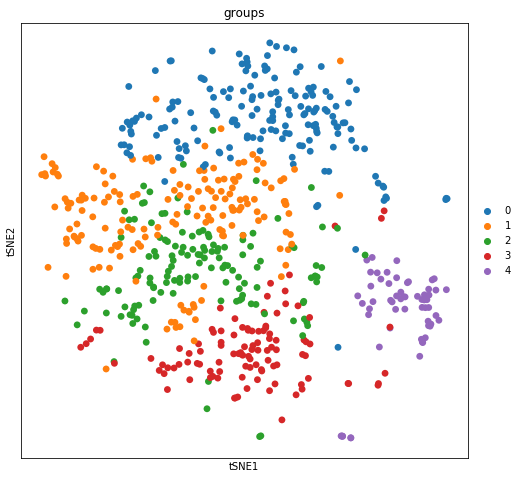

In [21]:
sc.tl.tsne(adata_merfish, perplexity = 100,  n_jobs=12)
sc.pl.tsne(adata_merfish, color = "groups")

... and spatial coordinates.

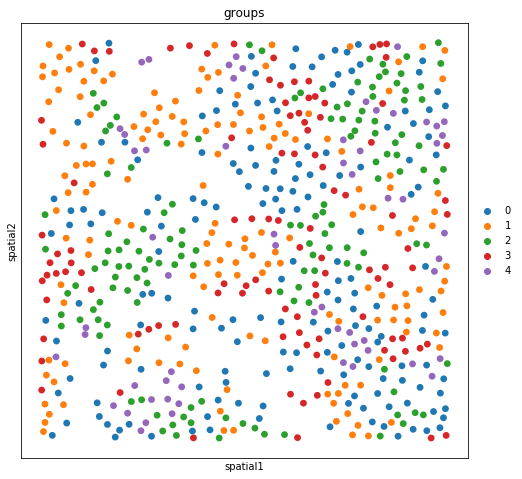

In [22]:
sc.pl.spatial(adata_merfish, color = "groups")

### Conclusion and future plans

This is the end of the tutorial, we hope you'll find it useful and [report back to us](https://github.com/theislab/scanpy/issues) which features/external tools you would like to see in Scanpy. 
We are extending Scanpy and AnnData to support other spatial data types, such as **Imaging Mass Cytometry** and extend data structure to support spatial graphs and additional features. Stay tuned!